In [1]:
using ITensors, ITensors.NDTensors
using LinearAlgebra
using OptimKit
using LBFGSB: lbfgsb
include("LBFGSBcall.jl")
using RecursiveArrayTools
import Random as rnd; rnd.seed!(1234)
import Distributions as dist
using LaTeXStrings
using Plots; pgfplotsx()
using BenchmarkTools

### Simulation parameters

In [2]:
# system parameters

# global dimension
NN::Int64 = 5
# local dimension
dd::Int64 = 3;

In [3]:
# time parameters
TT::Float64 = 50.
dt::Float64 = 0.025;

In [4]:
# Hamiltonian parameters
twopi = 2 * π
omega_1 = 5 * twopi
omega_2 = 5.5 * twopi
delta_1 = -0.35 * twopi
omega_r = 7.5 * twopi
g_1 = 0.1 * twopi
g_2 = g_1

Delta_1 = omega_1 - omega_r
Delta_2 = omega_2 - omega_r
omega_tilde_1 = omega_1 + (g_1^2 / Delta_1)
omega_tilde_2 = omega_2 + (g_2^2 / Delta_2)

JJ = (g_1 * g_2 * (Delta_1 + Delta_2)) / (Delta_1 * Delta_2)
Delta = omega_tilde_2 - omega_tilde_1;

In [5]:
# scaling constants and MPS cutoff
e_unit::Float64 = abs(JJ)
t_unit::Float64 = 1 / e_unit

cutoff::Float64 = 1E-8;

In [6]:
# Hamiltonian final parameters

seed = 1234
rng = rnd.MersenneTwister(seed)

# sample from a gaussian distribution
perc = 0.1
Deltas = rnd.rand(dist.Normal(Delta, abs(perc * Delta)), NN) / e_unit
deltas = rnd.rand(dist.Normal(delta_1, abs(perc * delta_1)), NN) / e_unit
JJs = rnd.rand(dist.Normal(JJ, abs(perc * JJ)), NN-1) / e_unit;

### Initialization functions

In [7]:
# defines simulation parameters
function inputparams(Τ::R=TT, τ::R=dt, unit::R=t_unit, info::Bool=true) where {R<:Real}
    nt = Τ / (τ * unit)
    res = nt % 1
    nt = trunc(Integer, nt)
    nψ = nt + 1

    if info
        println("eff time window:\t", round(Τ - res * τ; digits=2), " ns")
        println("nr time steps:\t\t", nt)
    end

    return nψ, τ
end;

In [8]:
# initializes the control vector
function initializectrls(n_iter::Int64, unit::Float64=e_unit)
    u_thr = 0.2 * 2 * π # 200 MHz
    return rnd.rand(dist.Uniform(-u_thr,u_thr), n_iter)  / unit
end;

In [9]:
# initialize problem
nctrl, dt = inputparams()
controls = initializectrls(nctrl)
sites = siteinds("Qudit", NN; dim=dd);

eff time window:	50.0 ns
nr time steps:		113


In [10]:
# initialize states

# ψ states
states = ["0" for n=1:NN]
psi0 = productMPS(sites, states)

# χ states
states = ["1" for n=1:NN]
chi0 = productMPS(sites, states);

### Unitary gates

In [11]:
# op for the Qudit SiteType
# https://github.com/ITensor/ITensors.jl/issues/957

# function ITensors.op(::OpName"R", ::SiteType"Qudit", s::Index) 
#   M = [0 0 0 0 0 0 0 0 2] 
#   return ITensor(M,s',s)
# end

function onesitegate(jj::Int64, ctrl::Float64, σ::Vector{Index{Int64}}=sites, Δs::V=Deltas, δs::V=deltas, τ::Float64=dt) where {V<:Vector{Float64}}
  one =
    ctrl * (op("a†", σ, jj) + op("a", σ, jj)) +
    Δs[jj] * op("N", σ, jj) +
    1/2 * δs[jj] * (op("N * N", σ, jj) - op("N", σ, jj)) # op("R", σ, jj)
  return exp(-im * τ/2 * one)
end

function twositegate(jj::Int64, σ::Vector{Index{Int64}}=sites, κs::V=JJs, τ::Float64=dt) where {V<:Vector{Float64}}
  two =
    κs[jj] * (op("a†b", σ, jj, jj+1) + op("ab†", σ, jj, jj+1))
    return exp(-im * τ * two)
end;

### Time evolution functions

In [12]:
# implements the MPS TEBD sweeps from https://arxiv.org/pdf/2008.06076.pdf (Fig. 7)
function buildgates(u_curr::Float64, u_next::Float64, nsites::Int64=NN)

    nfwd = 3 * (nsites ÷ 2)
    nbwd = 3 * ((nsites-1) ÷ 2)
    ngates = nfwd + nbwd + 2

    gates = Vector{ITensor}(undef, ngates)

    # even and odd indices
    odd = 1:2:(nsites-1)
    even = reverse(setdiff(2:nsites-1, odd))

    # forward sweep
    for (ii, jj) in enumerate(odd)
        UC_1 = onesitegate(jj, u_curr)
        UC_2 = onesitegate(jj+1, u_curr)
        UD   = twositegate(jj)

        x = (ii-1) * 3
        gates[x+1:x+3] = [UC_1, UC_2, UD]
    end

    iseven(nsites) ? u_last = u_next : u_last = u_curr
    UC_last  = onesitegate(nsites, u_last)
    gates[nfwd+1] = UC_last

    # backward sweep
    for (ii,jj) in enumerate(even)
        UD   = twositegate(jj)
        UC_3 = onesitegate(jj+1, u_next)
        UC_2 = onesitegate(jj, u_next)

        x = nfwd + 1 + (ii-1) * 3
        gates[x+1:x+3] = [UD, UC_3, UC_2]
    end

    UC_first = onesitegate(1, u_next)
    gates[ngates] = UC_first

    return gates
end;

In [13]:
# CHECK: forward and backward evolution

one_step = copy(psi0)

psi_gates = buildgates(controls[1], controls[2])
chi_gates = dag.(reverse(psi_gates))

one_step = apply(psi_gates, one_step; cutoff=1E-8)
normalize!(one_step)
one_step = apply(chi_gates, one_step; cutoff=1E-8)
normalize!(one_step)

println("⟨ ψ | ψ ⟩ =\t", inner(psi0, psi0))
println("⟨ 1 | 1 ⟩ =\t", inner(one_step, one_step))
println("⟨ 1 | ψ ⟩ =\t", inner(one_step, psi0))

⟨ ψ | ψ ⟩ =	1.0
⟨ 1 | 1 ⟩ =	

1.0000000000000009 + 0.0im
⟨ 1 | ψ ⟩ =	

0.999999999999899 - 4.163336342344337e-16im


In [14]:
# implements the forward- and backward state time evolution
function evolvestate(ctrl::Vector{Float64}, ψini::MPS, χtgt::MPS, nsites::Int64=NN, ε::Float64=cutoff)
    
    nψ = size(ctrl,1)
    ngates = 3 * ((nsites ÷ 2) + ((nsites-1) ÷ 2)) + 2
    
    evψ = Vector{MPS}(undef, nψ)
    evχ = Vector{MPS}(undef, nψ)
    trotter = Vector{ITensor}(undef, ngates * (nψ-1))

    evψ[1] = ψini
    evχ[1] = χtgt

    for n in 1:nψ-1
        ψgates = buildgates(ctrl[n], ctrl[n+1])
        ψ = apply(ψgates, evψ[n]; cutoff=ε)
        normalize!(ψ)
        evψ[n+1] = ψ
        trotter[1+ngates*(n-1):ngates*n] = ψgates
    end

    trotter = reverse(trotter)

    for n in 1:nψ-1
        χgates = dag.(trotter[1+ngates*(n-1):ngates*n])
        χ = apply(χgates, evχ[n]; cutoff=ε)
        normalize!(χ)
        evχ[n+1] = χ
    end

    overlap = inner(first(evχ), last(evψ))

    return evψ, reverse(evχ), overlap
end;

In [15]:
# CHECK: verify | ⟨ χ | ψ ⟩ |² constant

function absoverlap(χ::MPS, ψ::MPS)
    return abs2(inner(χ, ψ))
end;

ev_psi, ev_chi, overlap = evolvestate(controls, psi0, chi0)

O = map(absoverlap, ev_chi, ev_psi)

println("max and min are equal up to the ~ ", round(-log10(maximum(O) - minimum(O)); digits=1), " digit")
println("Suzuki-Trotter expansion of error log(δt²) ~ ", round(-log10(dt^2); digits=2))

max and min are equal up to the ~ 5.4 digit
Suzuki-Trotter expansion of error log(δt²) ~ 3.2


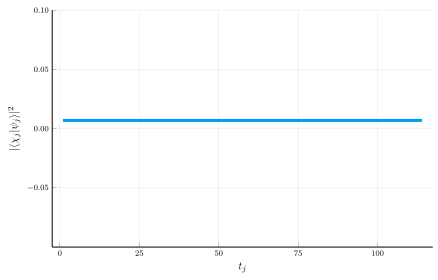

In [16]:
p = plot(O, lw = 3, legend=false, ylim=(-0.1, 0.1))
xlabel!(p, L"t_j")
ylabel!(p, L"|\langle\chi_j|\psi_j\rangle|^2")

### Jensen derivative method

In [17]:
# initializes the MPO of the problem
function buildMPO(σ::Vector{Index{Int64}}=sites)
  ampoMPS = OpSum()
  for jj=1:NN
      ampoMPS += "a†",jj
      ampoMPS += "a",jj
  end
  return MPO(ampoMPS,σ)  
end

ham = buildMPO();

In [18]:
# implements Jensen's method, returning both the fidelity and gradient
function jensen(ctrl::Vector{Float64}, ψini::MPS=psi0, χtgt::MPS=chi0, H::MPO=ham, τ::Float64=dt)
    N = length(ctrl)
    evψ, evχ, overlap = evolvestate(ctrl, ψini, χtgt)
    f = 1/2 * (1 - abs2(overlap))
    sandwich = [inner(χ', H, ψ) for (χ, ψ) in zip(evχ, evψ)]
    sandwich[1] *= 1/2
    sandwich[N] *= 1/2
    g = real(im * conj(overlap) * sandwich) * τ
    return (f, g)
end;

In [19]:
# bound = 0.2 * 2 * π / e_unit
# jfout, jxout, jnormgrad = LBFGSBcall(jensen, controls, bound);

In [20]:
# println("final fidelity Jensen: \t", 1 - last(jfout)*2)
# p = plot(2*jfout, lw=2, label="jensen", legend=:bottomleft, yaxis=:log)
# xlabel!(p, "iteration")
# ylabel!(p, L"1-\mathcal{F}")

In [21]:
# p = plot(jxout, lw=2, label="jensen", legend=:bottomleft)
# plot!(controls, lw=2, label="start")
# xlabel!(p, "iteration")
# ylabel!(p, L"1-\mathcal{F}")

In [22]:
u_thr = 0.2 * 2 * π / e_unit
fout, xout = lbfgsb(jensen, controls, lb=-u_thr, ub=u_thr, m=2, factr=1e7, pgtol=1e-5, iprint=1, maxfun=15000, maxiter=250); # ∼5' run time

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =            2

At X0         0 variables are exactly at the bounds



At iterate    0    f=  4.96556D-01    |proj g|=  1.47489D-03



At iterate    1    f=  4.96520D-01    |proj g|=  1.48427D-03


  ys=-2.388E-07  -gs= 3.662E-05 BFGS update SKIPPED



At iterate    2    f=  4.52453D-01    |proj g|=  5.91302D-03



At iterate    3    f=  4.51258D-01    |proj g|=  6.21068D-03



At iterate    4    f=  3.90607D-01    |proj g|=  8.76695D-03


  ys=-3.120E-03  -gs= 5.582E-02 BFGS update SKIPPED



At iterate    5    f=  3.52188D-01    |proj g|=  1.02955D-02



At iterate    6    f=  2.93483D-01    |proj g|=  1.24840D-02



At iterate    7    f=  2.68823D-01    |proj g|=  1.04031D-02



At iterate    8    f=  2.21885D-01    |proj g|=  1.02460D-02



At iterate    9    f=  2.03193D-01    |proj g|=  6.49427D-03



At iterate   10    f=  1.61234D-01    |proj g|=  5.34321D-03



At iterate   11    f=  1.35066D-01    |proj g|=  1.14248D-02



At iterate   12    f=  1.12720D-01    |proj g|=  5.65007D-03



At iterate   13    f=  1.02770D-01    |proj g|=  5.19762D-03



At iterate   14    f=  8.55657D-02    |proj g|=  5.38113D-03



At iterate   15    f=  6.80123D-02    |proj g|=  4.21924D-03



At iterate   16    f=  6.31573D-02    |proj g|=  3.38762D-03



At iterate   17    f=  6.11855D-02    |proj g|=  1.62881D-03



At iterate   18    f=  5.98606D-02    |proj g|=  1.56662D-03



At iterate   19    f=  5.77379D-02    |proj g|=  2.03216D-03



At iterate   20    f=  5.59183D-02    |proj g|=  4.88625D-03



At iterate   21    f=  5.29210D-02    |proj g|=  2.90356D-03



At iterate   22    f=  5.06506D-02    |proj g|=  2.86119D-03



At iterate   23    f=  4.62423D-02    |proj g|=  2.35748D-03



At iterate   24    f=  4.47064D-02    |proj g|=  1.86975D-03



At iterate   25    f=  4.38016D-02    |proj g|=  1.20767D-03



At iterate   26    f=  4.29823D-02    |proj g|=  1.19601D-03



At iterate   27    f=  4.25854D-02    |proj g|=  1.75025D-03



At iterate   28    f=  4.20248D-02    |proj g|=  9.56077D-04



At iterate   29    f=  4.11690D-02    |proj g|=  1.38490D-03



At iterate   30    f=  4.04615D-02    |proj g|=  1.73790D-03



At iterate   31    f=  3.86012D-02    |proj g|=  1.16287D-03



At iterate   32    f=  3.78827D-02    |proj g|=  1.93565D-03



At iterate   33    f=  3.69289D-02    |proj g|=  1.01244D-03



At iterate   34    f=  3.64746D-02    |proj g|=  9.04798D-04



At iterate   35    f=  3.58551D-02    |proj g|=  1.15592D-03



At iterate   36    f=  3.55651D-02    |proj g|=  3.64626D-03



At iterate   37    f=  3.39490D-02    |proj g|=  1.24772D-03



At iterate   38    f=  3.34155D-02    |proj g|=  1.24189D-03



At iterate   39    f=  3.24519D-02    |proj g|=  1.73656D-03



At iterate   40    f=  3.13394D-02    |proj g|=  2.66767D-03



At iterate   41    f=  3.00043D-02    |proj g|=  1.59321D-03



At iterate   42    f=  2.96367D-02    |proj g|=  1.42929D-03



At iterate   43    f=  2.79159D-02    |proj g|=  1.99568D-03



At iterate   44    f=  2.70774D-02    |proj g|=  1.97054D-03



At iterate   45    f=  2.64036D-02    |proj g|=  1.34813D-03



At iterate   46    f=  2.59378D-02    |proj g|=  1.18061D-03



At iterate   47    f=  2.48627D-02    |proj g|=  1.76471D-03



At iterate   48    f=  2.48572D-02    |proj g|=  3.92305D-03



At iterate   49    f=  2.33112D-02    |proj g|=  1.42190D-03



At iterate   50    f=  2.27639D-02    |proj g|=  9.48706D-04



At iterate   51    f=  2.20623D-02    |proj g|=  1.33642D-03



At iterate   52    f=  2.14523D-02    |proj g|=  1.45053D-03



At iterate   53    f=  2.11628D-02    |proj g|=  9.90683D-04



At iterate   54    f=  2.10383D-02    |proj g|=  6.36540D-04



At iterate   55    f=  2.08329D-02    |proj g|=  7.42137D-04



At iterate   56    f=  2.05251D-02    |proj g|=  1.08072D-03



At iterate   57    f=  1.99112D-02    |proj g|=  9.26231D-04



At iterate   58    f=  1.95790D-02    |proj g|=  1.38963D-03



At iterate   59    f=  1.91900D-02    |proj g|=  5.97065D-04



At iterate   60    f=  1.90867D-02    |proj g|=  5.57328D-04



At iterate   61    f=  1.87670D-02    |proj g|=  7.56462D-04



At iterate   62    f=  1.84644D-02    |proj g|=  1.27998D-03



At iterate   63    f=  1.81871D-02    |proj g|=  1.04695D-03



At iterate   64    f=  1.80401D-02    |proj g|=  8.01933D-04



At iterate   65    f=  1.78600D-02    |proj g|=  7.77831D-04



At iterate   66    f=  1.77352D-02    |proj g|=  9.45328D-04



At iterate   67    f=  1.75634D-02    |proj g|=  8.41733D-04



At iterate   68    f=  1.69320D-02    |proj g|=  1.15435D-03



At iterate   69    f=  1.66084D-02    |proj g|=  1.38101D-03



At iterate   70    f=  1.62319D-02    |proj g|=  8.39256D-04



At iterate   71    f=  1.58862D-02    |proj g|=  9.64872D-04



At iterate   72    f=  1.56276D-02    |proj g|=  1.06469D-03



At iterate   73    f=  1.50692D-02    |proj g|=  1.18176D-03



At iterate   74    f=  1.48231D-02    |proj g|=  1.29558D-03



At iterate   75    f=  1.46029D-02    |proj g|=  9.06228D-04



At iterate   76    f=  1.43500D-02    |proj g|=  6.46433D-04



At iterate   77    f=  1.41858D-02    |proj g|=  7.92709D-04



At iterate   78    f=  1.40119D-02    |proj g|=  5.82730D-04



At iterate   79    f=  1.38028D-02    |proj g|=  4.81700D-04



At iterate   80    f=  1.36124D-02    |proj g|=  9.00498D-04



At iterate   81    f=  1.34307D-02    |proj g|=  8.00936D-04



At iterate   82    f=  1.33140D-02    |proj g|=  7.22754D-04



At iterate   83    f=  1.29609D-02    |proj g|=  6.88657D-04



At iterate   84    f=  1.27970D-02    |proj g|=  9.81223D-04



At iterate   85    f=  1.26305D-02    |proj g|=  6.03684D-04



At iterate   86    f=  1.25657D-02    |proj g|=  5.19847D-04



At iterate   87    f=  1.22985D-02    |proj g|=  5.72450D-04



At iterate   88    f=  1.22175D-02    |proj g|=  7.32434D-04



At iterate   89    f=  1.21565D-02    |proj g|=  5.57997D-04



At iterate   90    f=  1.20583D-02    |proj g|=  4.71524D-04



At iterate   91    f=  1.19564D-02    |proj g|=  4.90258D-04



At iterate   92    f=  1.18722D-02    |proj g|=  5.37049D-04



At iterate   93    f=  1.17999D-02    |proj g|=  3.58920D-04



At iterate   94    f=  1.17134D-02    |proj g|=  3.77416D-04



At iterate   95    f=  1.16211D-02    |proj g|=  6.89263D-04



At iterate   96    f=  1.15077D-02    |proj g|=  4.34618D-04



At iterate   97    f=  1.13706D-02    |proj g|=  5.49623D-04



At iterate   98    f=  1.10581D-02    |proj g|=  8.02163D-04



At iterate   99    f=  1.09630D-02    |proj g|=  5.19969D-04



At iterate  100    f=  1.09046D-02    |proj g|=  5.07131D-04



At iterate  101    f=  1.08448D-02    |proj g|=  9.48541D-04



At iterate  102    f=  1.06741D-02    |proj g|=  3.73957D-04



At iterate  103    f=  1.06263D-02    |proj g|=  3.68337D-04



At iterate  104    f=  1.05009D-02    |proj g|=  4.28764D-04



At iterate  105    f=  1.04073D-02    |proj g|=  3.15488D-04



At iterate  106    f=  1.03526D-02    |proj g|=  3.14673D-04



At iterate  107    f=  1.02718D-02    |proj g|=  4.27100D-04



At iterate  108    f=  1.02115D-02    |proj g|=  1.01355D-03



At iterate  109    f=  1.01058D-02    |proj g|=  3.69794D-04



At iterate  110    f=  1.00758D-02    |proj g|=  3.95224D-04



At iterate  111    f=  1.00121D-02    |proj g|=  3.77880D-04



At iterate  112    f=  9.95241D-03    |proj g|=  5.70431D-04



At iterate  113    f=  9.90390D-03    |proj g|=  2.44045D-04



At iterate  114    f=  9.87951D-03    |proj g|=  3.15026D-04



At iterate  115    f=  9.81869D-03    |proj g|=  3.81605D-04



At iterate  116    f=  9.78336D-03    |proj g|=  4.14162D-04



At iterate  117    f=  9.74593D-03    |proj g|=  3.53926D-04



At iterate  118    f=  9.72390D-03    |proj g|=  2.87445D-04



At iterate  119    f=  9.69464D-03    |proj g|=  2.53072D-04



At iterate  120    f=  9.62010D-03    |proj g|=  4.25756D-04



At iterate  121    f=  9.54752D-03    |proj g|=  4.60856D-04



At iterate  122    f=  9.49190D-03    |proj g|=  5.04189D-04



At iterate  123    f=  9.43971D-03    |proj g|=  3.29428D-04



At iterate  124    f=  9.37235D-03    |proj g|=  3.31131D-04



At iterate  125    f=  9.34799D-03    |proj g|=  6.10446D-04



At iterate  126    f=  9.29893D-03    |proj g|=  3.03170D-04



At iterate  127    f=  9.28020D-03    |proj g|=  2.49654D-04



At iterate  128    f=  9.25019D-03    |proj g|=  3.35822D-04



At iterate  129    f=  9.20385D-03    |proj g|=  2.77794D-04



At iterate  130    f=  9.18768D-03    |proj g|=  3.83912D-04



At iterate  131    f=  9.16878D-03    |proj g|=  3.61732D-04



At iterate  132    f=  9.13408D-03    |proj g|=  2.36486D-04



At iterate  133    f=  9.10513D-03    |proj g|=  3.29024D-04



At iterate  134    f=  9.07952D-03    |proj g|=  2.57667D-04



At iterate  135    f=  9.05183D-03    |proj g|=  2.83869D-04



At iterate  136    f=  8.98592D-03    |proj g|=  4.07688D-04



At iterate  137    f=  8.95733D-03    |proj g|=  5.03553D-04



At iterate  138    f=  8.92401D-03    |proj g|=  4.73656D-04



At iterate  139    f=  8.86180D-03    |proj g|=  3.52494D-04



At iterate  140    f=  8.82753D-03    |proj g|=  5.05814D-04



At iterate  141    f=  8.78981D-03    |proj g|=  3.75602D-04



At iterate  142    f=  8.74579D-03    |proj g|=  2.55876D-04



At iterate  143    f=  8.70626D-03    |proj g|=  3.14890D-04



At iterate  144    f=  8.70441D-03    |proj g|=  8.19536D-04



At iterate  145    f=  8.62531D-03    |proj g|=  2.99692D-04



At iterate  146    f=  8.61362D-03    |proj g|=  2.31448D-04



At iterate  147    f=  8.57400D-03    |proj g|=  3.19391D-04



At iterate  148    f=  8.54156D-03    |proj g|=  1.96283D-04



At iterate  149    f=  8.51683D-03    |proj g|=  3.25628D-04



At iterate  150    f=  8.48721D-03    |proj g|=  3.41247D-04



At iterate  151    f=  8.46367D-03    |proj g|=  2.64792D-04



At iterate  152    f=  8.41788D-03    |proj g|=  3.23797D-04



At iterate  153    f=  8.38982D-03    |proj g|=  3.61390D-04



At iterate  154    f=  8.36305D-03    |proj g|=  1.72098D-04



At iterate  155    f=  8.35485D-03    |proj g|=  1.47200D-04



At iterate  156    f=  8.34210D-03    |proj g|=  1.69655D-04



At iterate  157    f=  8.31386D-03    |proj g|=  3.18357D-04



At iterate  158    f=  8.30905D-03    |proj g|=  4.59537D-04



At iterate  159    f=  8.28367D-03    |proj g|=  2.59569D-04



At iterate  160    f=  8.27135D-03    |proj g|=  2.12925D-04



At iterate  161    f=  8.25302D-03    |proj g|=  2.37381D-04



At iterate  162    f=  8.22909D-03    |proj g|=  1.85505D-04



At iterate  163    f=  8.20801D-03    |proj g|=  2.34542D-04



At iterate  164    f=  8.19016D-03    |proj g|=  2.54645D-04



At iterate  165    f=  8.17535D-03    |proj g|=  2.37315D-04



At iterate  166    f=  8.13699D-03    |proj g|=  2.57202D-04



At iterate  167    f=  8.12412D-03    |proj g|=  2.35455D-04



At iterate  168    f=  8.11423D-03    |proj g|=  2.16970D-04



At iterate  169    f=  8.07667D-03    |proj g|=  2.62399D-04



At iterate  170    f=  8.07172D-03    |proj g|=  3.81176D-04



At iterate  171    f=  8.05059D-03    |proj g|=  2.06853D-04



At iterate  172    f=  8.03566D-03    |proj g|=  1.48229D-04



At iterate  173    f=  8.00637D-03    |proj g|=  3.12994D-04



At iterate  174    f=  7.97975D-03    |proj g|=  2.25942D-04



At iterate  175    f=  7.97860D-03    |proj g|=  4.49847D-04



At iterate  176    f=  7.95134D-03    |proj g|=  2.36686D-04



At iterate  177    f=  7.93540D-03    |proj g|=  2.09849D-04



At iterate  178    f=  7.91815D-03    |proj g|=  2.87229D-04



At iterate  179    f=  7.88963D-03    |proj g|=  3.09275D-04



At iterate  180    f=  7.87650D-03    |proj g|=  5.15716D-04



At iterate  181    f=  7.83729D-03    |proj g|=  3.09826D-04



At iterate  182    f=  7.82593D-03    |proj g|=  1.91091D-04



At iterate  183    f=  7.80823D-03    |proj g|=  2.08378D-04



At iterate  184    f=  7.78947D-03    |proj g|=  2.13647D-04



At iterate  185    f=  7.76093D-03    |proj g|=  2.77943D-04



At iterate  186    f=  7.73616D-03    |proj g|=  3.82750D-04



At iterate  187    f=  7.71612D-03    |proj g|=  2.58579D-04



At iterate  188    f=  7.70565D-03    |proj g|=  2.17031D-04



At iterate  189    f=  7.66989D-03    |proj g|=  2.39993D-04



At iterate  190    f=  7.65886D-03    |proj g|=  2.70338D-04



At iterate  191    f=  7.64776D-03    |proj g|=  2.42495D-04



At iterate  192    f=  7.61987D-03    |proj g|=  3.01878D-04



At iterate  193    f=  7.61803D-03    |proj g|=  4.17896D-04



At iterate  194    f=  7.60200D-03    |proj g|=  1.43287D-04



At iterate  195    f=  7.59831D-03    |proj g|=  9.43766D-05



At iterate  196    f=  7.58628D-03    |proj g|=  1.21534D-04



At iterate  197    f=  7.57698D-03    |proj g|=  1.26070D-04



At iterate  198    f=  7.56962D-03    |proj g|=  3.02999D-04



At iterate  199    f=  7.55907D-03    |proj g|=  1.85189D-04



At iterate  200    f=  7.55519D-03    |proj g|=  1.14640D-04



At iterate  201    f=  7.54794D-03    |proj g|=  1.11430D-04



At iterate  202    f=  7.54049D-03    |proj g|=  1.00878D-04



At iterate  203    f=  7.52993D-03    |proj g|=  8.77053D-05



At iterate  204    f=  7.52541D-03    |proj g|=  1.71015D-04



At iterate  205    f=  7.51836D-03    |proj g|=  1.52181D-04



At iterate  206    f=  7.49789D-03    |proj g|=  1.91785D-04



At iterate  207    f=  7.48629D-03    |proj g|=  1.89167D-04



At iterate  208    f=  7.47793D-03    |proj g|=  1.92438D-04



At iterate  209    f=  7.45126D-03    |proj g|=  2.41424D-04



At iterate  210    f=  7.42726D-03    |proj g|=  2.63450D-04



At iterate  211    f=  7.41127D-03    |proj g|=  2.27170D-04



At iterate  212    f=  7.38829D-03    |proj g|=  2.58463D-04



At iterate  213    f=  7.38003D-03    |proj g|=  1.43331D-04



At iterate  214    f=  7.37634D-03    |proj g|=  1.21905D-04



At iterate  215    f=  7.36681D-03    |proj g|=  1.71571D-04



At iterate  216    f=  7.36126D-03    |proj g|=  3.34268D-04



At iterate  217    f=  7.34859D-03    |proj g|=  1.78757D-04



At iterate  218    f=  7.33352D-03    |proj g|=  2.00071D-04



At iterate  219    f=  7.31638D-03    |proj g|=  2.39374D-04



At iterate  220    f=  7.30390D-03    |proj g|=  2.63211D-04



At iterate  221    f=  7.29473D-03    |proj g|=  3.02657D-04



At iterate  222    f=  7.27038D-03    |proj g|=  2.08230D-04



At iterate  223    f=  7.26291D-03    |proj g|=  2.94190D-04



At iterate  224    f=  7.25539D-03    |proj g|=  2.17075D-04



At iterate  225    f=  7.24615D-03    |proj g|=  2.63566D-04



At iterate  226    f=  7.23990D-03    |proj g|=  4.12831D-04



At iterate  227    f=  7.23306D-03    |proj g|=  3.84938D-04



At iterate  228    f=  7.21022D-03    |proj g|=  1.70110D-04



At iterate  229    f=  7.20156D-03    |proj g|=  1.43361D-04



At iterate  230    f=  7.17787D-03    |proj g|=  1.88112D-04



At iterate  231    f=  7.16140D-03    |proj g|=  2.23280D-04



At iterate  232    f=  7.14964D-03    |proj g|=  1.54297D-04



At iterate  233    f=  7.13331D-03    |proj g|=  1.98301D-04



At iterate  234    f=  7.10581D-03    |proj g|=  3.79737D-04



At iterate  235    f=  7.08749D-03    |proj g|=  1.57583D-04



At iterate  236    f=  7.08035D-03    |proj g|=  1.44412D-04



At iterate  237    f=  7.04042D-03    |proj g|=  2.35759D-04



At iterate  238    f=  7.03914D-03    |proj g|=  5.57295D-04



At iterate  239    f=  7.00474D-03    |proj g|=  2.43405D-04



At iterate  240    f=  6.99115D-03    |proj g|=  2.19876D-04



At iterate  241    f=  6.97910D-03    |proj g|=  1.55926D-04



At iterate  242    f=  6.96365D-03    |proj g|=  1.21815D-04



At iterate  243    f=  6.95303D-03    |proj g|=  2.50956D-04



At iterate  244    f=  6.93270D-03    |proj g|=  2.01363D-04



At iterate  245    f=  6.91051D-03    |proj g|=  2.38569D-04



At iterate  246    f=  6.85687D-03    |proj g|=  2.71095D-04



At iterate  247    f=  6.84763D-03    |proj g|=  1.52041D-04



At iterate  248    f=  6.84263D-03    |proj g|=  1.41042D-04



At iterate  249    f=  6.83028D-03    |proj g|=  1.03036D-04



At iterate  250    f=  6.82328D-03    |proj g|=  1.44079D-04



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114    250    282    266     2     1   1.441D-04   6.823D-03
  F =   6.8232767050818710E-003

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

 Cauchy                time 3.632E-03 seconds.
 Subspace minimization time 2.335E-03 seconds.
 Line search           time 1.776E+03 seconds.

 Total User time 1.786E+03 seconds.



In [23]:
println("final fidelity: ", 1 - fout*2)

final fidelity: 0.9863534465898363


In [24]:
# for 5 sites:
#     - 100  iterations: 0.9941621185371383 ∼ 2.5min
#     - 500  iterations: 0.9977799758946048 ∼ 110min
#     - 1000 iterations: 0.9990496158260205 ∼ 130min


# linesearch = HagerZhangLineSearch(; c₁=0.1, c₂=0.9, ϵ=1e-6, θ=1 / 2, γ=2 / 3, ρ=5.0, verbosity=0)
# algorithm = LBFGS(5; maxiter=100, gradtol=1e-8, linesearch=linesearch)
# x, fx, gx, numfg, normgradhistory = optimize(jensen, controls, algorithm);

In [25]:
# println("final fidelity: ", 1 - fx*2)
# p = plot(2*normgradhistory[:,1], lw = 3, legend=false)
# xlabel!(p, "iteration") # log-scale
# ylabel!(p, L"1-\mathcal{F}")

In [26]:
# p = plot(normgradhistory[:,2], lw = 3, legend=false)
# xlabel!(p, "iteration")
# ylabel!(p, L"||\nabla J_F||")

In [27]:
@benchmark jensen($controls)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.409 s …    2.084 s  ┊ GC (min … max): 5.64% … 6.58%
 Time  (median):     1.675 s               ┊ GC (median):    5.57%
 Time  (mean ± σ):   1.723 s ± 340.086 ms  ┊ GC (mean ± σ):  6.00% ± 0.56%

  █                     █                                  █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.41 s         Histogram: frequency by time         2.08 s <

 Memory estimate: 734.92 MiB, allocs estimate: 2662237.

### Automatic differentiation

In [28]:
using Zygote
using Zygote: Buffer,  @ignore
using ChainRulesCore
using ProfileView

### `ChainRulesCore.rrule` for gates

In [29]:
function ChainRulesCore.rrule(::typeof(normalize), ψ::MPS)
    ψn = normalize(ψ)
    nrm  = norm(ψ)
    maxdim = maxlinkdim(ψ)
  
    function pullback_normalize(c̄)
        ∂ψ = add(c̄/nrm, -1/nrm^3 * real(inner(ψ,c̄)) * ψ, maxdim=maxdim)
        return NoTangent(), ∂ψ
    end
    return ψn, pullback_normalize
end;

In [30]:
function ChainRulesCore.rrule(::typeof(onesitegate), jj::Int64, ctrl::Float64,
    σ::Vector{Index{Int64}}=sites, Δs::V=Deltas, δs::V=deltas, τ::Float64=dt) where {V<:Vector{Float64}}

    gate = onesitegate(jj, ctrl, σ, Δs, δs, τ)
  
    function pullback_gate(c̄)
        ∂jj  = NoTangent()
        ∂σ   = ZeroTangent()
        ∂Δs  = ZeroTangent()
        ∂δs  = ZeroTangent()
        ∂τ   = ZeroTangent()

        # here something is wrong: check for non-commutativity of derivative
        ops = gate * prime(op("a†", σ, jj) + op("a", σ, jj)) # j,j' * j',j'' -> j,j''
        setprime!(setprime!(ops, 1, plev=0), 0, plev=2)      # j,j'' -> j',j
        ∂u = τ/2 * imag(scalar(ops * dag(c̄)))                # j',j * j,j' -> scalar

        return (NoTangent(), ∂jj, ∂u, ∂σ, ∂Δs, ∂δs, ∂τ)
    end
    return gate, pullback_gate
end;

In [31]:
function ChainRulesCore.rrule(::typeof(twositegate), jj::Int64, σ::Vector{Index{Int64}}=sites, κs::V=JJs, τ::Float64=dt) where {V<:Vector{Float64}}

    gate = twositegate(jj, σ, κs, τ)
  
    function pullback_gate(c̄)
        ∂jj  = NoTangent()
        ∂σ   = NoTangent()
        ∂κs  = NoTangent()
        ∂τ   = NoTangent()

        return (NoTangent(), ∂jj, ∂σ, ∂κs, ∂τ)
    end
    return gate, pullback_gate
end;

In [32]:
function buildgatesAD(u_curr::Float64, u_next::Float64, nsites::Int64=NN)

    nfwd = 3 * (nsites ÷ 2)
    nbwd = 3 * ((nsites-1) ÷ 2)
    ngates = nfwd + nbwd + 2

    gates = Buffer(Vector{ITensor}(), ngates)

    # even and odd indices
    odd = 1:2:(nsites-1)
    even = @ignore reverse(setdiff(2:nsites-1, odd))

    # forward sweep
    for (ii, jj) in enumerate(odd)
        UC_1 = onesitegate(jj, u_curr)
        UC_2 = onesitegate(jj+1, u_curr)
        UD   = twositegate(jj)

        x = (ii-1) * 3
        gates[x+1:x+3] = [UC_1, UC_2, UD]
    end

    iseven(nsites) ? u_last = u_next : u_last = u_curr
    UC_last  = onesitegate(nsites, u_last)
    gates[nfwd+1] = UC_last

    # backward sweep
    for (ii,jj) in enumerate(even)
        UD   = twositegate(jj)
        UC_3 = onesitegate(jj+1, u_next)
        UC_2 = onesitegate(jj, u_next)

        x = nfwd + 1 + (ii-1) * 3
        gates[x+1:x+3] = [UD, UC_3, UC_2]
    end

    UC_first = onesitegate(1, u_next)
    gates[ngates] = UC_first

    return copy(gates)
end;

In [33]:
# backward time evolution is no more necessary, since the gradient is computed via AD
function evolvestateAD(ctrl::Vector{Float64}, ψini::MPS, χtgt::MPS, nsites::Int64=NN, ε::Float64=cutoff)
    
    nψ = size(ctrl,1)
    ψ = ψini

    for n in 1:nψ-1
        ψgates = buildgatesAD(ctrl[n], ctrl[n+1])
        ψ = apply(ψgates, ψ; cutoff=ε)
        ψ = normalize(ψ)
    end

    return 1/2 * (1 - abs2(inner(χtgt, ψ)))
end;

In [34]:
energy(x) = evolvestateAD(x, psi0, chi0);

In [35]:
from_AD = gradient(energy, controls)[1]
from_jensen = jensen(controls)[2];

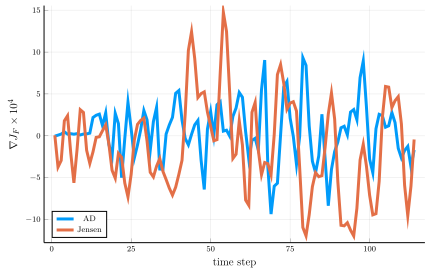

In [36]:
# compare gradients computed via AD vs Jensen's method
p = plot(from_AD*1e4, lw = 3, label="AD", legend=:bottomleft)
plot!(p, from_jensen*1e4, lw=3, label="Jensen")
xlabel!(p, "time step")
ylabel!(p, L"\nabla J_F\times 10^4")

In [37]:
# run the optimization with the AD-computed gradient

function AD(x)
    y, (∇,) = withgradient(energy, x)
    return y, ∇
end;

In [38]:
fout, xout = lbfgsb(AD, controls, lb=-u_thr, ub=u_thr, m=2, factr=1e7, pgtol=1e-5, iprint=1, maxfun=15000, maxiter=250); # ∼30'' run time

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =            2

At X0         0 variables are exactly at the bounds



At iterate    0    f=  4.96556D-01    |proj g|=  9.33875D-04



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114      1     21      1     0     0   9.339D-04   4.966D-01
  F =  0.49655588386288130     

ABNORMAL_TERMINATION_IN_LNSRCH                              

 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization time 0.000E+00 seconds.
 Line search           time 0.000E+00 seconds.

 Total User time 1.603E+02 seconds.



In [39]:
println("final fidelity: ", 1 - fout*2)

final fidelity: 0.006888232274237405


In [40]:
@benchmark AD($controls)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.567 s …    1.827 s  ┊ GC (min … max): 7.25% … 7.61%
 Time  (median):     1.656 s               ┊ GC (median):    7.55%
 Time  (mean ± σ):   1.683 s ± 132.461 ms  ┊ GC (mean ± σ):  7.48% ± 0.19%

  █                  █                                     █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.57 s         Histogram: frequency by time         1.83 s <

 Memory estimate: 1.12 GiB, allocs estimate: 4165723.